## Import Libraries

In [5]:
import os
import gc
import random
import GPUtil
import warnings
import unicodedata
import multiprocessing
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from simpletransformers.t5 import T5Model
from sumeval.metrics.rouge import RougeCalculator
from tqdm.notebook import tqdm

pd.set_option('display.max_colwidth', 10000)
warnings.simplefilter('ignore')

In [6]:
class Cfg:
    seed = 42
    cuda = torch.cuda.is_available()
    prefix = 'easy_japanese'

In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(Cfg.seed)

In [8]:
# やさしい日本語コーパス: https://www.jnlp.org/GengoHouse/snow/t15
data = pd.read_excel('../data/easy_japanese_corpus/T15-2020.1.7.xlsx', index_col=0)
# やさしい日本語拡張コーパス: https://www.jnlp.org/GengoHouse/snow/t23
ext_data = pd.read_excel('../data/easy_japanese_corpus/T23-2020.1.7.xlsx', index_col=0)

In [9]:
data = data[['#日本語(原文)','#やさしい日本語']].reset_index(drop=True)
ext_data = ext_data[['#日本語(原文)','#やさしい日本語']].reset_index(drop=True)

## Quick EDA

In [10]:
display(data.head(1))
display(ext_data.head(1))

,#日本語(原文),#やさしい日本語
0,誰が一番に着くか私には分かりません。,誰が一番に着くか私には分かりません。


,#日本語(原文),#やさしい日本語
0,あなたのご都合の良い時にその仕事をして下さい。,あなたの具合の良い時にその仕事をしください。


In [11]:
# '原文' と 'やさしい日本語' のRouge1(unigram単位の比較)をスコアリングしてみる
rouge = RougeCalculator(stopwords=True, lang='ja')

data['rouge_1'] = [rouge.rouge_n(summary=data['#日本語(原文)'].iloc[i],
                                 references=data['#やさしい日本語'].iloc[i],
                                 n=1) for i in range(len(data))]

ext_data['rouge_1'] = [rouge.rouge_n(summary=ext_data['#日本語(原文)'].iloc[i],
                                     references=ext_data['#やさしい日本語'].iloc[i],
                                     n=1) for i in range(len(ext_data))]

In [12]:
print(f'T15 Rouge1 Stats: \n{data.rouge_1.describe()}\n')
print()
print(f'T23 拡張コーパス Rouge1 Stats: \n{ext_data.rouge_1.describe()}')

T15 Rouge1 Stats: 
count    50000.000000
mean         0.850036
std          0.179815
min          0.000000
25%          0.750000
50%          0.900000
75%          1.000000
max          1.000000
Name: rouge_1, dtype: float64


T23 拡張コーパス Rouge1 Stats: 
count    34300.000000
mean         0.666876
std          0.195493
min          0.000000
25%          0.538462
50%          0.700000
75%          0.823529
max          1.000000
Name: rouge_1, dtype: float64


In [13]:
# Rouge1スコアを元に、ピアソン相関係数を算出
display(data.drop(['#日本語(原文)','#やさしい日本語'],axis=1).corrwith(ext_data.drop(['#日本語(原文)','#やさしい日本語'],axis=1)))

rouge_1    0.001205
dtype: float64

## Preprocess

In [14]:
# SimpleTransformers mT5に入力可能な形へリネーム
data = data.rename(columns={'#日本語(原文)':'input_text','#やさしい日本語':'target_text'})
ext_data = ext_data.rename(columns={'#日本語(原文)':'input_text','#やさしい日本語':'target_text'})

data = data[['input_text','target_text']].reset_index(drop=True)
ext_data = ext_data[['input_text','target_text']].reset_index(drop=True)

In [15]:
# input_textとtarget_textが完全一致しているデータを検出する

def str_comparison(input, target):
    if input == target:
        return True
    else:
        return False

def apply_strComparison(df):
    df['match'] = [str_comparison(sample['input_text'],sample['target_text']) for sample in df.to_dict(orient='records')]
    return df

data = apply_strComparison(data)
ext_data = apply_strComparison(ext_data)

In [16]:
print(f'【T15】input_textとtarget_textの完全一致の件数\n{data.match.value_counts()}\n')
print()
print(f'【T23:拡張コーパス】input_textとtarget_textの完全一致の件数\n{ext_data.match.value_counts()}')

【T15】input_textとtarget_textの完全一致の件数
False    28643
True     21357
Name: match, dtype: int64


【T23:拡張コーパス】input_textとtarget_textの完全一致の件数
False    34115
True       185
Name: match, dtype: int64


## validation戦略

・input_textとtarget_textの完全一致データと、Not完全一致データを分ける。

・別々に、train/val/testの形で切る。

・別々に切った、train/val/testをそれぞれ結合することで、割合を崩さずにデータセットを作れる。

In [17]:
def text_normalize(text):
    text = text.strip()
    text = unicodedata.normalize('NFKC', text)
    return text

def apply_preprocess(data, ext_data, config):
    # ２つのデータセットの区別をつけるためカラム作成
    data['ver'] = 't15'
    ext_data['ver'] = 't23'
    dataset = pd.concat([data,ext_data])
    dataset['prefix'] = config.prefix
    # 正規化
    dataset['input_text'] = dataset['input_text'].apply(lambda x: text_normalize(x))
    dataset['target_text'] = dataset['target_text'].apply(lambda x: text_normalize(x))
    # target_textがinput_textより10文字以上多いデータを削除
    dataset['input_len'] = dataset.input_text.apply(lambda x: len(x))
    dataset['target_len'] = dataset.target_text.apply(lambda x: len(x))
    dataset = dataset.query('(target_len - input_len) < 10')
    dataset = dataset.drop(['input_len','target_len'], axis=1)
    # 完全一致データと、Not完全一致データを分ける
    match_ds = dataset.query('match == True').reset_index(drop=True)
    notMatch_ds = dataset.query('match == False').reset_index(drop=True)
    return match_ds, notMatch_ds

match_ds, notMatch_ds = apply_preprocess(data, ext_data, Cfg)

In [18]:
display(match_ds.head(1))
display(notMatch_ds.head(1))

,input_text,target_text,match,ver,prefix
0,誰が一番に着くか私には分かりません。,誰が一番に着くか私には分かりません。,True,t15,easy_japanese


,input_text,target_text,match,ver,prefix
0,多くの動物が人間によって滅ぼされた。,多くの動物が人間によって殺された。,False,t15,easy_japanese


In [19]:
print(f'完全一致データセットのinput_textカラムの文字数統計量 \n {match_ds.input_text.apply(lambda x: len(x)).describe()}\n')
print(f'完全一致データセットのtarget_textカラムの文字数統計量 \n {match_ds.target_text.apply(lambda x: len(x)).describe()}')
print()
print(f'Not完全一致データセットのinput_textカラムの文字数統計量 \n {notMatch_ds.input_text.apply(lambda x: len(x)).describe()}\n')
print(f'Not完全一致データセットのtarget_textカラムの文字数統計量 \n {notMatch_ds.target_text.apply(lambda x: len(x)).describe()}')

完全一致データセットのinput_textカラムの文字数統計量 
 count    21542.000000
mean        14.358463
std          3.631958
min          4.000000
25%         12.000000
50%         14.000000
75%         17.000000
max         45.000000
Name: input_text, dtype: float64

完全一致データセットのtarget_textカラムの文字数統計量 
 count    21542.000000
mean        14.358463
std          3.631958
min          4.000000
25%         12.000000
50%         14.000000
75%         17.000000
max         45.000000
Name: target_text, dtype: float64

Not完全一致データセットのinput_textカラムの文字数統計量 
 count    59768.000000
mean        17.275549
std          6.066322
min          5.000000
25%         13.000000
50%         16.000000
75%         20.000000
max         66.000000
Name: input_text, dtype: float64

Not完全一致データセットのtarget_textカラムの文字数統計量 
 count    59768.000000
mean        18.359590
std          6.357867
min          2.000000
25%         14.000000
50%         17.000000
75%         21.000000
max         72.000000
Name: target_text, dtype: float64


In [20]:
def train_val_test_split(dataset, config):
    '''
    T15とT23の相関係数の値が極めて少ない為、
    その2つをクラスとして層別にtrain/val/testを切る
    '''
    train, test = train_test_split(
        dataset, 
        test_size=0.2, 
        random_state=config.seed, 
        stratify=dataset['ver']
        )
    train, val = train_test_split(
        train, 
        test_size=0.2, 
        random_state=config.seed, 
        stratify=train['ver']
        )
    train = train[['input_text','target_text','prefix']]
    val = val[['input_text','target_text','prefix']]
    test = test[['input_text','target_text','prefix']]
    return train, val, test

def create_dataset(match_dataset, notMatch_dataset, config):
    # 別々に、train/val/testの形で切る
    mtrain, mval, mtest = train_val_test_split(match_dataset, config)
    nmtrain, nmval, nmtest = train_val_test_split(notMatch_dataset, config)
    # 別々に切った、train/val/testをそれぞれ結合
    train = pd.concat([mtrain,nmtrain]).reset_index(drop=True)
    val = pd.concat([mval,nmval]).reset_index(drop=True)
    test = pd.concat([mtest,nmtest]).reset_index(drop=True)
    return train, val, test


train, val, test = create_dataset(match_ds, notMatch_ds, Cfg)

In [21]:
train.head(1)

,input_text,target_text,prefix
0,何を待っているんだ?,何を待っているんだ?,easy_japanese


In [22]:
print(f'Train: {len(train)}')
print(f'Val: {len(val)}')
print(f'Test: {len(test)}')

Train: 52037
Val: 13010
Test: 16263


## FineTuning: stage1

In [23]:
train_params = {
    'gradient_accumulation_steps': 2,
    'repetition_penalty': 1.5,
    'learning_rate': 1e-4, 
    'max_seq_length': 64, 
    'max_length': 64, 
    'train_batch_size': 32, 
    'eval_batch_size': 32, 
    'num_train_epochs': 30,
    'evaluate_during_training': True,
    'evaluate_during_training_steps': 10000,
    'use_multiprocessing': False,
    'fp16': False,
    'save_steps': -1,
    'save_eval_checkpoints': False,
    'save_model_every_epoch': False,
    'no_cache': True,
    'overwrite_output_dir': True,
    'preprocess_inputs': False,
    'early_stopping_consider_epochs': True, 
    'output_dir': 'stage1_outputs/',
    'best_model_dir': 'stage1_outputs/best_model',
    'dataloader_num_workers': multiprocessing.cpu_count()
}

model = T5Model('mt5', 'google/mt5-small', args=train_params, use_cuda=Cfg.cuda)
model.train_model(train, eval_data=val)

Downloading:   0%|          | 0.00/553 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

  0%|          | 0/52037 [00:00<?, ?it/s]

Using Adafactor for T5


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Running Epoch 0 of 30:   0%|          | 0/1627 [00:00<?, ?it/s]

  0%|          | 0/13010 [00:00<?, ?it/s]

Running Epoch 1 of 30:   0%|          | 0/1627 [00:00<?, ?it/s]

  0%|          | 0/13010 [00:00<?, ?it/s]

Running Epoch 2 of 30:   0%|          | 0/1627 [00:00<?, ?it/s]

  0%|          | 0/13010 [00:00<?, ?it/s]

Running Epoch 3 of 30:   0%|          | 0/1627 [00:00<?, ?it/s]

  0%|          | 0/13010 [00:00<?, ?it/s]

Running Epoch 4 of 30:   0%|          | 0/1627 [00:00<?, ?it/s]

  0%|          | 0/13010 [00:00<?, ?it/s]

Running Epoch 5 of 30:   0%|          | 0/1627 [00:00<?, ?it/s]

  0%|          | 0/13010 [00:00<?, ?it/s]

Running Epoch 6 of 30:   0%|          | 0/1627 [00:00<?, ?it/s]

  0%|          | 0/13010 [00:00<?, ?it/s]

Running Epoch 7 of 30:   0%|          | 0/1627 [00:00<?, ?it/s]

  0%|          | 0/13010 [00:00<?, ?it/s]

Running Epoch 8 of 30:   0%|          | 0/1627 [00:00<?, ?it/s]

  0%|          | 0/13010 [00:00<?, ?it/s]

Running Epoch 9 of 30:   0%|          | 0/1627 [00:00<?, ?it/s]

  0%|          | 0/13010 [00:00<?, ?it/s]

Running Epoch 10 of 30:   0%|          | 0/1627 [00:00<?, ?it/s]

  0%|          | 0/13010 [00:00<?, ?it/s]

Running Epoch 11 of 30:   0%|          | 0/1627 [00:00<?, ?it/s]

  0%|          | 0/13010 [00:00<?, ?it/s]

Running Epoch 12 of 30:   0%|          | 0/1627 [00:00<?, ?it/s]

  0%|          | 0/13010 [00:00<?, ?it/s]

  0%|          | 0/13010 [00:00<?, ?it/s]

Running Epoch 13 of 30:   0%|          | 0/1627 [00:00<?, ?it/s]

  0%|          | 0/13010 [00:00<?, ?it/s]

Running Epoch 14 of 30:   0%|          | 0/1627 [00:00<?, ?it/s]

  0%|          | 0/13010 [00:00<?, ?it/s]

Running Epoch 15 of 30:   0%|          | 0/1627 [00:00<?, ?it/s]

  0%|          | 0/13010 [00:00<?, ?it/s]

Running Epoch 16 of 30:   0%|          | 0/1627 [00:00<?, ?it/s]

  0%|          | 0/13010 [00:00<?, ?it/s]

Running Epoch 17 of 30:   0%|          | 0/1627 [00:00<?, ?it/s]

  0%|          | 0/13010 [00:00<?, ?it/s]

Running Epoch 18 of 30:   0%|          | 0/1627 [00:00<?, ?it/s]

  0%|          | 0/13010 [00:00<?, ?it/s]

Running Epoch 19 of 30:   0%|          | 0/1627 [00:00<?, ?it/s]

  0%|          | 0/13010 [00:00<?, ?it/s]

Running Epoch 20 of 30:   0%|          | 0/1627 [00:00<?, ?it/s]

  0%|          | 0/13010 [00:00<?, ?it/s]

Running Epoch 21 of 30:   0%|          | 0/1627 [00:00<?, ?it/s]

  0%|          | 0/13010 [00:00<?, ?it/s]

Running Epoch 22 of 30:   0%|          | 0/1627 [00:00<?, ?it/s]

  0%|          | 0/13010 [00:00<?, ?it/s]

Running Epoch 23 of 30:   0%|          | 0/1627 [00:00<?, ?it/s]

  0%|          | 0/13010 [00:00<?, ?it/s]

Running Epoch 24 of 30:   0%|          | 0/1627 [00:00<?, ?it/s]

  0%|          | 0/13010 [00:00<?, ?it/s]

  0%|          | 0/13010 [00:00<?, ?it/s]

Running Epoch 25 of 30:   0%|          | 0/1627 [00:00<?, ?it/s]

  0%|          | 0/13010 [00:00<?, ?it/s]

Running Epoch 26 of 30:   0%|          | 0/1627 [00:00<?, ?it/s]

  0%|          | 0/13010 [00:00<?, ?it/s]

Running Epoch 27 of 30:   0%|          | 0/1627 [00:00<?, ?it/s]

  0%|          | 0/13010 [00:00<?, ?it/s]

Running Epoch 28 of 30:   0%|          | 0/1627 [00:00<?, ?it/s]

  0%|          | 0/13010 [00:00<?, ?it/s]

Running Epoch 29 of 30:   0%|          | 0/1627 [00:00<?, ?it/s]

  0%|          | 0/13010 [00:00<?, ?it/s]

(24390,
 {'eval_loss': [2.275774935686032,
   1.5690918855680294,
   1.296727290953663,
   1.1523548279630353,
   1.055525417723384,
   1.0053924767721527,
   0.959812944928866,
   0.9414962253736959,
   0.9271510226402606,
   0.893157570374585,
   0.8735015385541653,
   0.8584634034290306,
   0.86263646420517,
   0.8505230352891202,
   0.8392347425259009,
   0.8441912548568475,
   0.8322875832793296,
   0.8203750824834922,
   0.8123893217476547,
   0.8108291451811233,
   0.8158020508047696,
   0.8051399527797224,
   0.8075141393624163,
   0.8150405274516461,
   0.8078877547228394,
   0.8153590011096923,
   0.8136750741991048,
   0.8046131359100919,
   0.8113626769963533,
   0.812269553147984,
   0.8118728154089476,
   0.8243460407568124],
  'global_step': [813,
   1626,
   2439,
   3252,
   4065,
   4878,
   5691,
   6504,
   7317,
   8130,
   8943,
   9756,
   10000,
   10569,
   11382,
   12195,
   13008,
   13821,
   14634,
   15447,
   16260,
   17073,
   17886,
   18699,
   19512

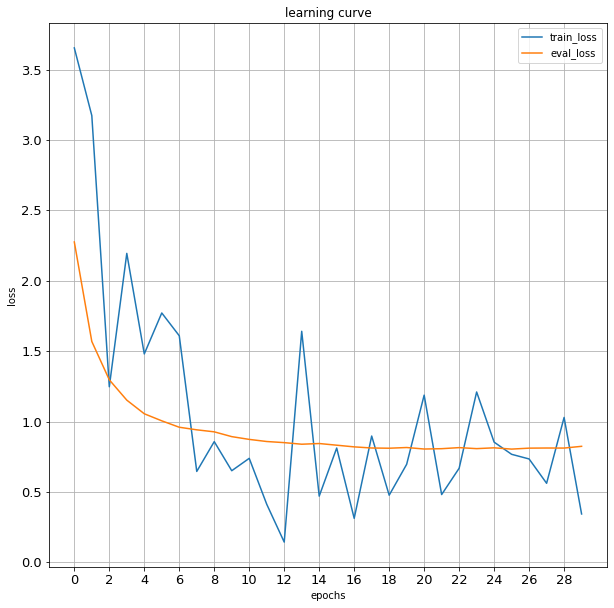

In [24]:
history = pd.read_csv('stage1_outputs/training_progress_scores.csv')
# epochsに相当しないtraining stepsは、ignoreする
history = history.query('global_step not in [10000,20000,30000,40000]').reset_index(drop=True)
epochs_history = history[['train_loss','eval_loss']]
epochs_history.plot(xticks=np.arange(0, len(epochs_history), 2), 
                    xlabel='epochs', ylabel='loss', figsize=(10,10), 
                    grid=True, title='learning curve', fontsize=13)

In [25]:
pred_params = {
    'max_seq_length': 64, 
    'use_multiprocessed_decoding': False,
    'num_beams': 9
}

model = T5Model('mt5', 'stage1_outputs/best_model', args=pred_params, use_cuda=Cfg.cuda)
stage1_preds = model.predict(list(test['input_text']))

Generating outputs:   0%|          | 0/509 [00:00<?, ?it/s]

In [26]:
# V-RAMのキャッシュをクリア
del model
gc.collect()
torch.cuda.empty_cache()

In [27]:
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 | 52% |  7% |


## FineTuning: stage2

validationデータを使って、1エポックのみファインチューニング

In [28]:
stage2_params = {
    'learning_rate': 3e-6, 
    'num_train_epochs': 1,
    'evaluate_during_training': False,
    'output_dir': 'stage2_outputs/'
}

train_params.update(stage2_params)

model = T5Model('mt5', 'stage1_outputs/best_model', args=train_params, use_cuda=Cfg.cuda)
model.train_model(val)

  0%|          | 0/13010 [00:00<?, ?it/s]

Using Adafactor for T5


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/407 [00:00<?, ?it/s]

(203, 0.9564837585822702)

In [29]:
model = T5Model('mt5', 'stage2_outputs', args=pred_params, use_cuda=Cfg.cuda)
stage2_preds = model.predict(list(test['input_text']))

Generating outputs:   0%|          | 0/509 [00:00<?, ?it/s]

## Evaluate

In [30]:
def rouge_calc(preds, targets):
    rouge = RougeCalculator(stopwords=True, lang='ja')
    rouge_1 = [rouge.rouge_n(summary=preds[i],references=targets[i],n=1) for i in range(len(preds))]
    rouge_2 = [rouge.rouge_n(summary=preds[i],references=targets[i],n=2) for i in range(len(preds))]
    rouge_l = [rouge.rouge_l(summary=preds[i],references=targets[i]) for i in range(len(preds))]

    return {'Rouge_1': np.array(rouge_1).mean(),
            'Rouge_2': np.array(rouge_2).mean(),
            'Rouge_L': np.array(rouge_l).mean()}

In [31]:
print(f'stage1モデルのRougeスコア: \n{rouge_calc(stage1_preds,list(test.target_text))}\n')
print()
print(f'stage2モデルのRougeスコア: \n{rouge_calc(stage2_preds,list(test.target_text))}\n')

stage1モデルのRougeスコア: 
{'Rouge_1': 0.8450137177971703, 'Rouge_2': 0.741395356404656, 'Rouge_L': 0.8417169724920458}


stage2モデルのRougeスコア: 
{'Rouge_1': 0.8461733636616718, 'Rouge_2': 0.743111072714148, 'Rouge_L': 0.8429615749348411}



In [32]:
pd.concat([test['input_text'],test['target_text'],pd.Series(stage2_preds, name='predict_text')], axis=1).sample(10, random_state=Cfg.seed)

,input_text,target_text,predict_text
387,映画館にいたんだ。,映画館にいたんだ。,映画館にいたんだ。
1261,彼は英語の試験で2つ間違った。,彼は英語の試験で2つ間違った。,彼は英語の試験で2つ間違った。
2546,どうか彼に会いに行ってください。,どうか彼に会いに行ってください。,どうか彼に会いに行ってください。
284,薬ができました。,薬ができました。,薬ができました。
7198,彼には音楽家の素質がある。,彼には音楽家の能力がある。,彼には音楽家の性格がある。
7277,彼は自発的に彼女を助けようとした。,彼は自分から彼女を助けようとした。,彼は自ら彼女を助けようとした。
2467,彼女が怒るのも当然だ。,彼女が怒るのも当然だ。,彼女が怒るのも当然だ。
6275,それに、もう庭も掘り起こしてしまったのよ。,それに、もう庭も土を反してしまったのよ。,それに、もう庭も壊してしまったのよ。
12127,彼は君を馬鹿とまでいった。,彼はあなたを馬鹿とまでいった。,彼はあなたを馬鹿とまでいった。
8498,卓球をしたいのですが。,スポーツをしたいのですが。,ボールを投げるスポーツをしたいのですが。
